In [15]:
import PyPDF2
import textract

def extract_text_pypdf2(pdf_path):
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfFileReader(file)
        text = ''
        for page_num in range(pdf_reader.numPages):
            page = pdf_reader.getPage(page_num)
            text += page.extractText()
    return text

def extract_text_textract(pdf_path):
    text = textract.process(pdf_path)
    return text.decode('utf-8')


In [61]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

def perform_sentiment_analysis(text, lexicon_emotion):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = {emotion: 0 for emotion in lexicon_emotion.keys()}

    for token in word_tokenize(text):
        if token in lexicon_emotion:
            token_emotions = lexicon_emotion[token]
            for emotion in token_emotions:
                sentiment_scores[emotion] += 1  # Increment by 1 for each occurrence

    # Normalize scores to a range of [-1, 1]
    max_score = max(sentiment_scores.values())
    if max_score != 0:
        for emotion, score in sentiment_scores.items():
            sentiment_scores[emotion] = (score / max_score) * 2 - 1

    return sentiment_scores


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nischal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [68]:
# generating wordcloud
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Save the word cloud as an imag
    plt.savefig("../results/word_cloud.png")
    plt.show()

def perform_sentiment_analysis(text, lexicon_emotion):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = {'pos': 0, 'neu': 0, 'neg': 0}

    for token in word_tokenize(text):
        if token in lexicon_emotion:
            token_emotions = lexicon_emotion[token]
            for emotion in token_emotions:
                # Map lexicon emotions to standard sentiment labels
                if emotion == 'positive':
                    sentiment_scores['pos'] += 1
                elif emotion == 'negative':
                    sentiment_scores['neg'] += 1

    # Use the SentimentIntensityAnalyzer for compound score
    compound_score = sid.polarity_scores(text)['compound']
    sentiment_scores['compound'] = compound_score

    return sentiment_scores


In [69]:
import os
import pandas as pd
import plotly.express as px
from nltk.tokenize import word_tokenize 

# Load the NRC Emotion Lexicon from the text file
def load_lexicon(file_path):
    lexicon_emotion = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word, emotion, value = line.strip().split('\t')
            if int(value) == 1:
                if word not in lexicon_emotion:
                    lexicon_emotion[word] = set() 
                lexicon_emotion[word].add(emotion)
    return lexicon_emotion

# path to the NRC Emotion Lexicon file
lexicon_file_path = '../data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'

# Load the lexicon
lexicon_emotion = load_lexicon(lexicon_file_path)

def analyze_pdfs_in_directory(directory):
    combined_sentiment_scores = {}
    sentiment_words = {}

    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(directory, filename)
            text = extract_text_textract(pdf_path)
            sentiment_scores = perform_sentiment_analysis(text, lexicon_emotion)

            # Accumulate sentiment scores
            for sentiment, score in sentiment_scores.items():
                combined_sentiment_scores[sentiment] = combined_sentiment_scores.get(sentiment, 0) + score

            # Collect sentiment words
            for token in word_tokenize(text): 
                if token in lexicon_emotion:
                    token_emotions = lexicon_emotion[token]
                    for emotion in token_emotions:
                        if emotion not in sentiment_words:
                            sentiment_words[emotion] = set()
                        sentiment_words[emotion].add(token)

            print(f"Sentiment scores for {filename}: {sentiment_scores}")

    # Print sentiment words
    for sentiment, words in sentiment_words.items():
        print(f"\nWords associated with {sentiment} sentiment:")
        print(words)

    # Convert sentiment dictionary to a DataFrame
    df_sentiment = pd.DataFrame.from_dict(combined_sentiment_scores, orient='index', columns=['Count'])
    df_sentiment.reset_index(inplace=True)
    df_sentiment.rename(columns={'index': 'Sentiment'}, inplace=True)

    # Create a pie chart using Plotly Express
    fig = px.pie(df_sentiment, names='Sentiment', values='Count', hole=0.4, 
                 title='Combined Sentiment Distribution',
                 labels={'Count': 'Percentage'},
                 color_discrete_sequence=px.colors.qualitative.Set3)

    
    fig.update_traces(textinfo='percent+label')
    fig.update_layout(template="seaborn", showlegend=False)

 
    fig.show()


In [70]:
analyze_pdfs_in_directory('/Users/nischal/Downloads/migration book')


Sentiment scores for undesa_pd_2020_international_migration_highlights-2.pdf: {'pos': 857, 'neu': 0, 'neg': 345, 'compound': 1.0}
Sentiment scores for NIC-2021-02486--Future-of-Migration--Unsourced--14May21.pdf: {'pos': 216, 'neu': 0, 'neg': 118, 'compound': 0.9983}
Sentiment scores for OECD Migration Policy Debates Numero 2.pdf: {'pos': 123, 'neu': 0, 'neg': 30, 'compound': 0.9998}
Sentiment scores for background_paper_en.pdf: {'pos': 124, 'neu': 0, 'neg': 34, 'compound': 0.9998}
Sentiment scores for Policy Paper - Geopolitical Outlook on International Migration.pdf: {'pos': 291, 'neu': 0, 'neg': 108, 'compound': 0.9996}

Words associated with positive sentiment:
{'assistance', 'experienced', 'immediately', 'deal', 'feature', 'scientific', 'reason', 'authorization', 'major', 'timely', 'main', 'grant', 'good', 'actual', 'continue', 'progress', 'reconstruction', 'encourage', 'precedence', 'ultimately', 'accessible', 'destination', 'complement', 'legal', 'explain', 'ease', 'assist', 'tec

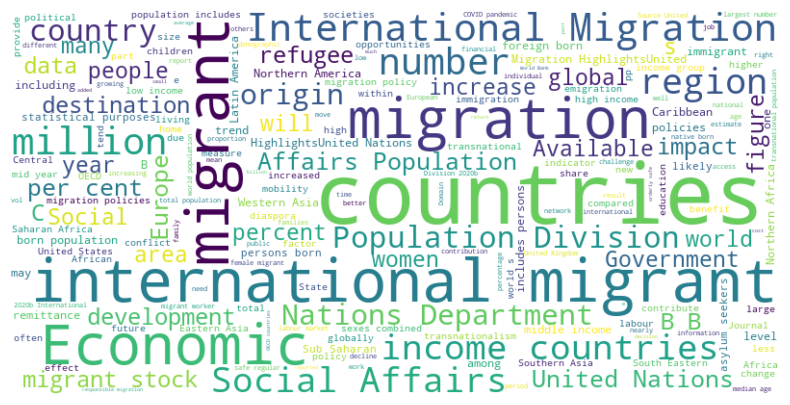

In [48]:
analyze_pdfs_and_generate_word_cloud('/Users/nischal/Downloads/migration book')